<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/Binary%20classification/Home%20Credit%20Default%20Risk/Introduction%20to%20Manual%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction : Manual Feature Engineering
- application 데이터만 사용했을 때, 리더보드 0.74를 기록하였다.
- 이 스코어를 뛰어넘기 위해 다른 데이터프레임을 활용하여 정보를 더 모으고자 한다.
- 본 커널에서는 bureau 및 breau_balance 데이터를 살펴본다.
- bureau: Home Credit에 제출된 고객(Cient)의 다른 금융기관에서의 과거 대출 기록(각각의 대출 기록은 각 열로 정리되어 있다.)
- bureau_balance: 과거 대출들의 월별 데이터(각 월별 데이터는 각각의 열로 정리되어있다.


- **수작업(Manual) Feature Engineering은 지루한 과정일 수 있다**.
- 또한 도메인 지식을 필요로 하기도 한다.
- 대출 및 채무 불이행의 주된 원인에 대한 지식을 갖추는데 한계가 있기 때문에 최종 학습용 데이터프레임에서 가능한 많은 정보를 얻는데 주안점을 두었다.
- 즉, 이 커널은 어떤 Feature들이 중요한지를 결정하는 것에 있어서, 사람보다 모델이 고르도록하는 접근방식을 취한다.
- 기본적으로 이러한 접근방식에서는 최대한 많은 Feature들을 만들고, 모델은 이러한 Feature들을 전부 활용한다.
- 추후 모델에서 얻어진 Feature Importance나 PCA를 통해 Feature Reduction을 할 수 있다.

- 수작업(Manual) Feature Engineering의 각 과정은 많은 양의 Pandas 코드와 약간의 인내심, 특히 데이터 처리에 있어서 많은 인내심을 필요로 한다. 
- 비록 자동화된 Feature Engineering 도구들이 활용되기 시작했지만, 당분간 Feature Engineering은 여전히 전처리 작업을 필요로 한다.

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# 예시: 고객의 이전 대출 수량 파악(Counts of a client's previous loans) 
Manual feature engineering의 보편적인 방법을 설명하기 위해, 먼저 고객의 과거 타 금융기관에서의 대출 수량을 간단히 파악하고자 함. 이 과정은 커널에서 반복적으로 사용되는 아래의 Pandas 명령어들을 포함한다.
- groupby: Column 값에 따라 데이터프레임을 그룹화. 이 과정에서는 SK_ID_CURR Column긔 값에 따라 고객별로 데이터프레임을 그룹화
- agg: 그룹화된 데이터의 평균 등을 계산.'grouped_df.mean()'을 통해 직접 평균을 계산 하거나 agg 명령어와 리스트를 활용하여 평균, 최대값, 최소값, 합계 등을 계산 (grouped_df.agg([mean, max, min, sum])
- merge: 집계된(aggregated) 값을 해당 고객과 매칭. SK_ID_CURR을 활용하여 집계된 값을 원본 트레이닝 데이터로 병합하고, 해당값이 없을 경우에는 NaN 값을 입력

또한 rename 명령어를 통해 Column을 dict를 활용하여 변경한다. 이러한 방식은 생성된 변수들을 계속해서 추적하는데 유용하다.

이러한 과정이 길게 느껴질 수도 있기 때문에, 추후 이러한 과정을 대신 해줄 함수를 작성할 예정이다. 우선 수작업으로 시행하는 과정을 살펴보자.

In [3]:
!pip install gcsfs

     |████████████████████████████████| 125 kB 8.5 MB/s 
     |████████████████████████████████| 1.3 MB 35.8 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 160 kB 55.3 MB/s 


In [4]:
GCS_DS_PATH = "gs://kds-d0a70a4ad71e03ff9b29989a414b7a65cce86b61c82476461cdc1bb3"
bureau = pd.read_csv(GCS_DS_PATH+'/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
# 고객 id(SK_ID_CURR)를 기준으로 groupby를 실행, 이전 대출 갯수를 파악하고, Column 이름을 변경
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={
    'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
# 훈련용 데이터프레임과 병합(Join)
train = pd.read_csv(GCS_DS_PATH+'/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

#NaN값에 0을 대입
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


우측 끝에 previous_loan_counts가 생성되었다.

# R Value를 활용한 변수 유용성 평가(Assessing Usefulness of New Variable with r value)
새롭게 생성된 column의 변수들이 유용한지 판단하기 위해 목표값(target)과 해당 변수 간의 피어슨 상관계수(Pearson Correlation Coefficient, r-value)를 계산
- 두 변수 사이의 선형관계는 -1~1 사이의 값으로 표현
- r-value가 변수의 유용성을 평가하기 위한 최선의 방식은 아니지만, 머신러닝 모델을 발전시키는데 효과가 있을지 대략적인 정보를 줄 수 있다.
- 목표값에 대한 r-value가 커질 수록 해당 변수가 목표값에 영향을 끼칠 가능성이 높아진다.
- 그러므로 목표값에 대해 가장 큰 r-value의 절대값을 가지는 변수를 찾고자 한다.
- 또한 우리는 커널밀도추정그래프(KDE plot)을 활용하여 목표값과의 상관관계를 시각적으로 살펴볼 것이다.


**커널밀도추정그래프(Kernel Density Estimate Plots)**
- 커널밀도추정그래프는 단일 변수의 분포를 보여준다.(히스토그램을 부드럽게한(smoothed)것으로 생각해보면 될 것이다.)
- 범주형 변수(Categorical Variable)의 값 차이에 따른 분포의 차이를 보기 위해, 카테고리에 따라 색을 다르게 칠하도록 함
- 예를 들어 Target 값이 0인지 1인지에 따라 색을 다르게 칠한 previous_loan_count의 커널밀도추정그래프를 그릴 수 있다.
- 이러한 그래프는 대출을 상환한 그룹(Target==0)과 그렇지 못한 그룹(Target==1)의 분포의 차이점을 보여줄 것이다.
- 이는 변수들이 머신러닝 모델과 관련성을 가지는 지를 보여줄 수 있는 지표로 활용될 수 있다.



In [26]:
train.loc[train['TARGET']==0,'EXT_SOURCE_3']

1              NaN
2         0.729567
3              NaN
4              NaN
5         0.621226
            ...   
307505    0.742182
307506         NaN
307507         NaN
307508    0.218859
307510    0.113922
Name: EXT_SOURCE_3, Length: 282686, dtype: float64

In [30]:
# 변수의 분포에 대한 그래프 target값에 따라 색을 달리하여 작성
def kde_target(var_name, df):
    '''
    Args
    
    input:
    
    var_name = str, 변수가 되는 Column
    df : DataFrame, 대상 데이터프레임
    
    
    return: None
    
    '''
    
    # 새롭게 생성된 변수와 target간의 상관계수를 계산
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # 대출의 상환한 그룹과 그렇지 않은 그룹의 중간값(median)계산
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET']==0,var_name].median()
    avg_not_repaid = df.loc[df['TARGET']==1,var_name].median()
    
    plt.figure(figsize = (12,6))
    
    # target값에 따라 색을 달리하여 그래프 작성
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET']==0,var_name],label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET']==1,var_name],label = 'TARGET == 1')
    
    # 그래프 라벨링
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # 상관계수 출력
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    
    # 중간값 출력
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

- ix 메서드 loc 로 변경
- Random Forest 및 Gradient Boosting Machine에 의해 가장 중요한 변수로 판명된 EXT_SOURCE_3를 활용하여 테스트하도록 한다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


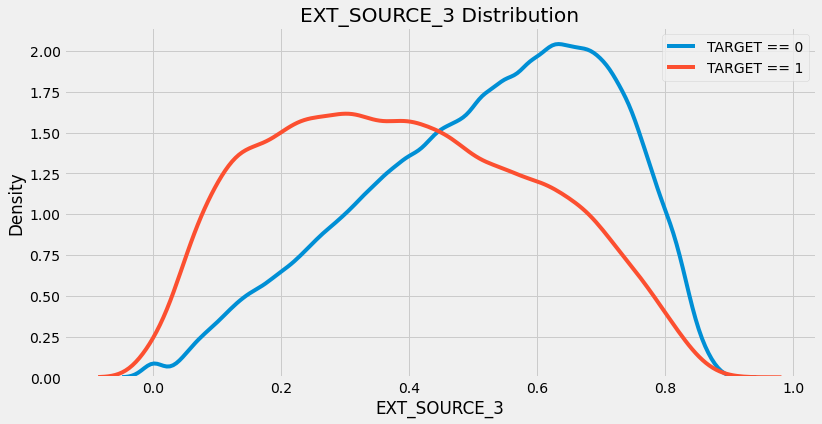

In [28]:
kde_target('EXT_SOURCE_3',train)

방금 새롭게 만들었던, previous_loan_counts를 살펴보도록 하겠습니다
- 예시 커널과 다름!!

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


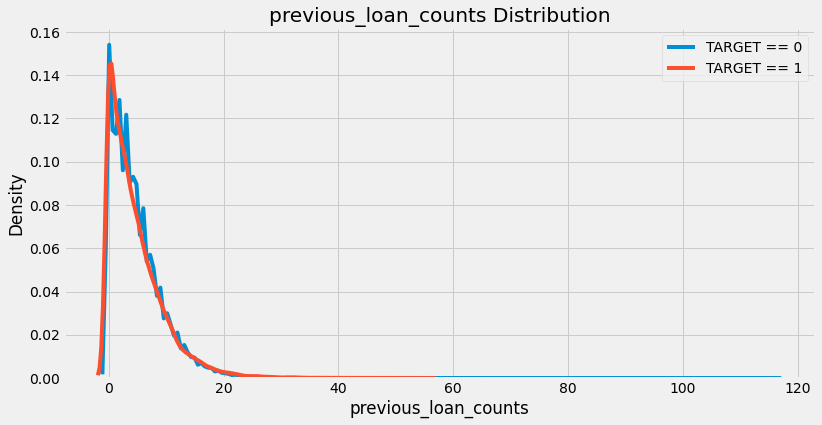

In [31]:
kde_target('previous_loan_counts',train)

이를 통해 새롭게 생성된 변수 (previous_loan_counts Distribution)가 별로 중요하지 않음을 알 수 있다.
- 상관계수가 너무 작음
- target 값에 따른 분포의 차이도 거의 없다.

이제 bureau 데이터프레임으로부터 몇개의 변수들을 새롭게 생성할 것
- bureau 데이터프레임의 모든 수치 데이터 Column(numeric column)들로부터 평균, 최소, 최대값을 가져올 예정

# 수치 데이터의 대표값들을 계산(Aggregating Numeric Columns)
- bureau 데이터 프레임 안의 수치 데이터를 활용하기 위해, 모든 수치 데이터 Column의 대표값들을 계산할 것
- 이를 위해 고객 ID 별로 그룹화를 수행하고, 그룹화된 데이터프레임의 대표값들을 agg를 통해 구한 뒤, 결과를 훈련 데이터셋과 병합한다.
- agg 함수는 오직 수치 데이터행들의 유효한 대표값들을 계산하는 역할을 수행한다
- mean, max, min, sum 함수를 기본으로 사용
- 상황에 따라 생략

In [32]:
# 고객 id에 따라 데이터프레임을 그룹화하고, 대표값들을 계산
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                    ...  AMT_ANNUITY                       
                   count         mean  max  ...         mean      max  min      sum
0     100001           7  -735.000000  -49  ...  3545.357143  10822.5  0.0  24817.5
1     100002           8  -874.000000 -103  ...     0.000000      0.0  0.0      0.0
2     100003           4 -1400.750000 -606  ...          NaN      NaN  NaN      0.0
3     100004           2  -867.000000 -408  ...          NaN      NaN  NaN      0.0
4     100005           3  -190.666667  -62  ...  1420.500000   4261.5  0.0   4261.5

[5 rows x 61 columns]

생성된 column들에 대해 새롭게 이름을 적어주는 것이 좋다.  
- 밑의 코드들은 원본 데이터의 Colummn에 대표값들의 종류들을 추가적으로 기입해주는 역할을 수행한다. 여기서는 Milti-Level index 데이터프레임을 작업의 대상으로 한다.
- 이러한 부분은 혼동을 줄 수 있고, 작업하기 어렵기 때문에, **single-level index**로 최대한 빠르게 변환함

In [39]:
# Column 리스트를 생성
columns = ['SK_ID_CURR']

# 변수에 따라 반복문을 실행
for var in bureau_agg.columns.levels[0]:
  
  # id column은 생략
  if var != 'SK_ID_CURR':
    
    # 대표값의 종류에 따라 반복문을 생성
    for stat in bureau_agg.columns.levels[1][:-1]:

      # 변수 및 대표값의 종류에 따라 새로운 column name을 생성
        columns.append('bureau_%s_%s' % (var,stat))

In [41]:
# 생성된 list를 데이터프레임의 column name으로 지정
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [42]:
# 훈련데이터와 병합
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,5.0,1681.029,5043.645,0.0,8405.145,8.0,0.0,0.0,0.0,0.0,8.0,108131.945625,450000.0,0.0,865055.565,5.0,49156.2,245781.0,0.0,245781.0,4.0,7997.14125,31988.565,0.0,31988.565,8.0,0.0,0.0,0.0,0.0,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,4.0,0.000,0.000,0.0,0.000,4.0,0.0,0.0,0.0,0.0,4.0,254350.125000,810000.0,22248.0,1017400.500,4.0,0.0,0.0,0.0,0.0,4.0,202500.00000,810000.000,0.0,810000.000,4.0,0.0,0.0,0.0,0.0,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,1.0,0.000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,94518.900000,94537.8,94500.0,189037.800,2.0,0.0,0.0,0.0,0.0,2.0,0.00000,0.000,0.0,0.000,2.0,0.0,0.0,0.0,0.0,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,

**목표값과 대표값들의 상관계수 분석(Correlations of Aggregated Values with Target)**
- 새롭게 생성된 값들과 목표값(target)과의 상관계수를 분석
- 상관계수는 중요한 변수들을 대략적으로 알려준다.


In [43]:
# 새로운 상관계수들에 대한 리스트 생성
new_corrs = []

# column 별로 반복문을 실행
for col in columns:
  # 목표값(target)과의 상관계수 계산
  corr = train['TARGET'].corr(train[col])

  # 튜플로 리스트에 추가
  new_corrs.append((col,corr))

- 밑에 sorted 함수를 통해 상관계수들을 절대값에 따라 정렬
- 익명의(anonymous) lambda (알아 놓으면 좋은 파이썬의 중요한 기능) 함수도 활용


In [56]:
# 상관계수들을 절대값에 따라 정렬
# 큰 값부터 앞에 나오게하기 위해서는 reverse를 True로 설정
new_corrs = sorted(new_corrs, key = lambda x:abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998114),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968673),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392077),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.0537348956010205),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758616),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997299),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115894),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.046982754334835494),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730155),
 ('bureau_DAYS_CREDIT_sum', 0.041999824814846716),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306002),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329094),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921616024),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325495)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


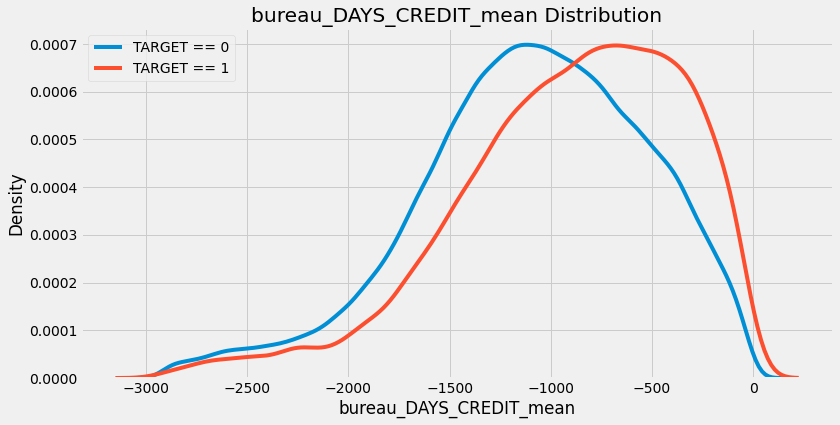

In [57]:
kde_target('bureau_DAYS_CREDIT_mean', train)

- 위 column은 고객이 신용관리국 신용등급을 신청한 날로부터 현 대출신청가지 걸린 기간은 몇 일인가? 에 관한 데이터이다.
-이것을 이전 대출을 받고나서 'Home Credit'에서 대출을 받기전까지 걸린 일수로 해석
- 마이너스 수치가 크다: 이전 대출이 이루어진 시점이 더 오래됐음
- 이 변수들과 Target이 양의 상관관계를 갖는다는 것은 더 오래된 과거에 대출을 신청했던 고객들은 'Home Credi'에서 대출을 상환할 가능성이 높다는 것을 의미
- 그러나 상관관계가 약하기 때문에 노이즈일 가능성도 있음
